IF4072 - Natural Language Processing
Year: 2021
PIC: Stephen Thajeb - 13518150
This is notebook for sentiment analysis on restaurant reviews (dataset: [Link](https://drive.google.com/file/d/1f3CWDgC82f3TL8-4bUVMrQIvUDkN-IKM/view?usp=sharing)).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [2]:
# from google.colab import drive 
# drive.mount('/content/drive')

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
import numpy as np
from gensim.models import Word2Vec
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
import pickle

# Data Exploration

In [5]:
restaurant_df = pd.read_csv("/content/drive/Shareddrives/NLP/Restaurants_Train_v2.csv")

In [6]:
print(restaurant_df.shape)
restaurant_df.head()

(3041, 46)


,text,aspectTerms/aspectTerm/0/_term,aspectTerms/aspectTerm/0/_polarity,aspectTerms/aspectTerm/0/_from,aspectTerms/aspectTerm/0/_to,aspectCategories/aspectCategory/0/_category,aspectCategories/aspectCategory/0/_polarity,_id,aspectCategories/aspectCategory/1/_category,aspectCategories/aspectCategory/1/_polarity,aspectTerms/aspectTerm/1/_term,aspectTerms/aspectTerm/1/_polarity,aspectTerms/aspectTerm/1/_from,aspectTerms/aspectTerm/1/_to,aspectTerms/aspectTerm/2/_term,aspectTerms/aspectTerm/2/_polarity,aspectTerms/aspectTerm/2/_from,aspectTerms/aspectTerm/2/_to,aspectTerms/aspectTerm/3/_term,aspectTerms/aspectTerm/3/_polarity,aspectTerms/aspectTerm/3/_from,aspectTerms/aspectTerm/3/_to,aspectTerms/aspectTerm/4/_term,aspectTerms/aspectTerm/4/_polarity,aspectTerms/aspectTerm/4/_from,aspectTerms/aspectTerm/4/_to,aspectTerms/aspectTerm/5/_term,aspectTerms/aspectTerm/5/_polarity,aspectTerms/aspectTerm/5/_from,aspectTerms/aspectTerm/5/_to,aspectTerms/aspectTerm/6/_term,aspectTerms/aspectTerm/6/_polarity,aspectTerms/aspectTerm/6/_from,aspectTerms/aspectTerm/6/_to,aspectCategories/aspectCategory/2/_category,aspectCategories/aspectCategory/2/_polarity,aspectTerms/aspectTerm/7/_term,aspectTerms/aspectTerm/7/_polarity,aspectTerms/aspectTerm/7/_from,aspectTerms/aspectTerm/7/_to,aspectCategories/aspectCategory/3/_category,aspectCategories/aspectCategory/3/_polarity,aspectTerms/aspectTerm/8/_term,aspectTerms/aspectTerm/8/_polarity,aspectTerms/aspectTerm/8/_from,aspectTerms/aspectTerm/8/_to
0,But the staff was so horrible to us.,staff,negative,8.0,13.0,service,negative,3121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"To be completely fair, the only redeeming fact...",food,positive,57.0,61.0,food,positive,2777,anecdotes/miscellaneous,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"The food is uniformly exceptional, with a very...",food,positive,4.0,8.0,food,positive,1634,NaN,NaN,kitchen,positive,55.0,62.0,menu,neutral,141.0,145.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Where Gabriela personaly greets you and recomm...,NaN,NaN,NaN,NaN,service,positive,2534,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"For those that go once and don't enjoy it, all...",NaN,NaN,NaN,NaN,anecdotes/miscellaneous,positive,583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Dataset has maximum 3 aspect appear in each row. With each aspect associate with some terms.

for each aspect there are 6 columns of information mainly:
1. aspectTerms/aspectTerm/{idx}/_term
2. aspectTerms/aspectTerm/{idx}/_polarity
3. aspectTerms/aspectTerm/{idx}/_from
4. aspectTerms/aspectTerm/{idx}/_to
5. aspectCategories/aspectCategory/{idx}/_category
6. aspectCategories/aspectCategory/{idx}/_polarity

There are 3 columsn of aspect category & 9 columns of aspect_terms </br>
term 0 is associated with aspect 0 </br>
term 1,2,...6  is associated with aspect 1 </br>
term 7 is associated with aspect 2 </br>
term 8 is associated with aspect 3 </br>

In [7]:
# key: aspect
# value: set of terms

def get_all_aspect():
  aspects = []
  for i in range(0,4):
    categories = restaurant_df[f'aspectCategories/aspectCategory/{i}/_category'].unique()
    print(categories)
    for category in categories:
      if not pd.isna(category) and category not in aspects:
        aspects.append(category)
  return aspects

print("Total aspect:", get_all_aspect())

['service' 'food' 'anecdotes/miscellaneous' 'ambience' 'price']
[nan 'anecdotes/miscellaneous' 'service' 'price' 'food' 'ambience']
[nan 'ambience' 'price' 'service' 'food' 'anecdotes/miscellaneous']
[nan 'price' 'food']
Total aspect: ['service', 'food', 'anecdotes/miscellaneous', 'ambience', 'price']


In [8]:
restaurant_df[f'aspectCategories/aspectCategory/{0}/_polarity'].unique()

array(['negative', 'positive', 'conflict', 'neutral'], dtype=object)

In [9]:
aspect_term_dict = {
  "service": set(),
  "food": set(),
  "anecdotes/miscellaneous": set(),
  "ambience": set(),
  "price": set(),
} #key: aspect, value: set of terms

POLARITY = {"positive": 1, "negative": -1, "neutral": 0, "conflict": 0}

def get_new_df(df):
  new_df = pd.DataFrame()
  new_df["text"] = restaurant_df["text"]
  aspects = get_all_aspect()

  for aspect in aspects:
    # set default polarity to neutral
    new_df[aspect] = POLARITY["neutral"]

  for row_index, row in restaurant_df.iterrows():
      for idx in range(0,4):
        category = row[f"aspectCategories/aspectCategory/{idx}/_category"]
        if not pd.isna(category):
          new_df.at[row_index,category] = POLARITY[row[f"aspectCategories/aspectCategory/{idx}/_polarity"]]

          # Inject terms into aspect based on csv columns
          if idx == 0:
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/0/_term"])
          if idx == 1:
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/1/_term"])
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/2/_term"])
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/3/_term"])
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/4/_term"])
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/5/_term"])
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/6/_term"])
          if idx == 2:
            aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/7/_term"])
          if idx == 3:
              aspect_term_dict[category].add(row[f"aspectTerms/aspectTerm/8/_term"])
      
  
  return new_df
        
new_df = get_new_df(restaurant_df)
new_df.head()

['service' 'food' 'anecdotes/miscellaneous' 'ambience' 'price']
[nan 'anecdotes/miscellaneous' 'service' 'price' 'food' 'ambience']
[nan 'ambience' 'price' 'service' 'food' 'anecdotes/miscellaneous']
[nan 'price' 'food']


,text,service,food,anecdotes/miscellaneous,ambience,price
0,But the staff was so horrible to us.,-1,0,0,0,0
1,"To be completely fair, the only redeeming fact...",0,1,-1,0,0
2,"The food is uniformly exceptional, with a very...",0,1,0,0,0
3,Where Gabriela personaly greets you and recomm...,1,0,0,0,0
4,"For those that go once and don't enjoy it, all...",0,0,1,0,0


In [10]:
for column in new_df.columns.drop("text"):
  print(new_df[column].value_counts())

 0    2499
 1     324
-1     218
Name: service, dtype: int64
 0    1965
 1     867
-1     209
Name: food, dtype: int64
 0    2298
 1     544
-1     199
Name: anecdotes/miscellaneous, dtype: int64
 0    2680
 1     263
-1      98
Name: ambience, dtype: int64
 0    2747
 1     179
-1     115
Name: price, dtype: int64


In [11]:
topic_df = pd.read_csv("/content/drive/Shareddrives/NLP/Restaurant_with_label_topic.csv")
topic_df.head()

,Unnamed: 0,text,Food Probability,Place Probability,Service Probability,Topic
0,0,But the staff was so horrible to us.,0.172804,0.169523,0.657673,Service
1,1,"To be completely fair, the only redeeming fact...",0.849726,0.077097,0.073177,Food
2,2,"The food is uniformly exceptional, with a very...",0.209022,0.739503,0.051475,Place
3,3,Where Gabriela personaly greets you and recomm...,0.656661,0.173410,0.169930,Food
4,4,"For those that go once and don't enjoy it, all...",0.178825,0.647609,0.173565,Place


In [12]:
def get_major_topic_sentiment(row):
  if row["topic"] == "Service": return row["service"]
  if row["topic"] == "Food": return row["food"]
  if row["topic"] == "Place": return row["ambience"]

new_df["topic"] = topic_df["Topic"]
Y = new_df.apply(lambda row: get_major_topic_sentiment(row), axis=1)
X = new_df["text"]
print(X.head(),Y.head())

0                 But the staff was so horrible to us.
1    To be completely fair, the only redeeming fact...
2    The food is uniformly exceptional, with a very...
3    Where Gabriela personaly greets you and recomm...
4    For those that go once and don't enjoy it, all...
Name: text, dtype: object 0   -1
1    1
2    0
3    0
4    0
dtype: int64


In [13]:
def get_preprocessed_text(text, joining=False, stemming=True, lemmatizing=False, tokenize=True, case_fold=True, punctuation_remove=True):
  tokenizer = nltk.RegexpTokenizer(r"\w+")
  stemmer = PorterStemmer()
  stop_words = set(stopwords.words('english'))
  REPLACE_WITH_SPACE = re.compile("(<br\s/><br\s/?)|(-)|(/)|(:).")

  if case_fold:
    text = text.lower()
  if punctuation_remove:
    text = REPLACE_WITH_SPACE.sub(" ", text)
  if tokenize:
    text = tokenizer.tokenize(text)
    # text = [token for token in text if token not in stop_words]
  if stemming:
    text = [stemmer.stem(w) for w in text]
  if lemmatizing:
    pass

  if joining:
    text = " ".join(text)
  
  return text

# Word Embedding

In [14]:
# CountVectorizer
vectorizer = CountVectorizer()

cv_data = X.map(lambda text: get_preprocessed_text(text, joining=True))
before_resampling = pd.DataFrame({"x": cv_data, "y": Y})

In [15]:
before_resampling.head()

,x,y
0,but the staff wa so horribl to us,-1
1,to be complet fair the onli redeem factor wa t...,1
2,the food is uniformli except with a veri capab...,0
3,where gabriela personali greet you and recomme...,0
4,for those that go onc and don t enjoy it all i...,0


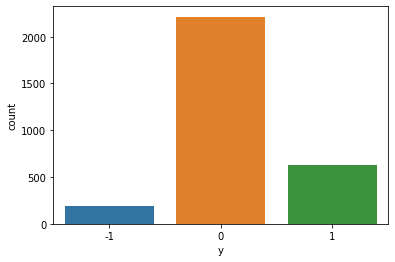

In [16]:
sns.countplot(x=before_resampling.y, data=before_resampling)

In [17]:
neg_class_count, pos_class_count, net_class_count = before_resampling.y.value_counts().sort_values()

In [18]:
# Resampling
# is_reducing: True, under-sampling technique is used. If False, over-sampling techniique is used
def resampling(df, is_reducing=True):
  df_neg_class = df[df["y"] == POLARITY["negative"]]
  df_net_class = df[df["y"] == POLARITY["neutral"]]
  df_pos_class = df[df["y"] == POLARITY["positive"]]
  new_df = None

  if is_reducing:
    df_net_class = df_net_class.sample(pos_class_count)
    df_neg_class = df_neg_class.sample(pos_class_count, replace=True)
    new_df = pd.concat([df_neg_class, df_net_class, df_pos_class], axis=0)
  else:
    df_pos_class = df_pos_class.sample(net_class_count, replace=True)
    df_neg_class = df_neg_class.sample(net_class_count, replace=True)
    new_df = pd.concat([df_neg_class, df_net_class, df_pos_class], axis=0)
  
  return new_df


## Resampling using under-sampling technique

In [19]:
after_resampling = resampling(before_resampling, is_reducing=True)
print(after_resampling.y.value_counts().sort_values())
X, Y = after_resampling["x"], after_resampling["y"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
vectorizer.fit_transform(list(X_train) + list(X_test))
X_train_vec = vectorizer.transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()

 1    632
 0    632
-1    632
Name: y, dtype: int64


In [20]:
logRegModel = LogisticRegression(random_state=0)
y_pred = logRegModel.fit(X_train_vec, y_train).predict(X_test_vec)

In [21]:
np.unique(y_pred)

array([-1,  0,  1])

In [22]:
print(accuracy_score(y_test, y_pred) * 100, '%')

75.5591054313099 %


In [23]:
def train_n_model(models, x_train, y_train):
  for key, model in models.items():
    print(f'Currently Training {key}')
    model.fit(x_train, y_train)

models = {
    "LogisticRegression": LogisticRegression(),
    # "MultinomialBM": MultinomialNB(),
    # 'SVM': svm.SVC(kernel = 'linear'),
    # 'RandomForest': RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    # 'XGBoost': XGBClassifier(),
    # 'AdaBoost': AdaBoostClassifier(),
}

train_n_model(models, X_train_vec, y_train)

Currently Training LogisticRegression


In [24]:
def pred_n_model(models, x_test, y_test):
  preds = {
      'models': [],
      "accuracy": [],
      "prediction": [],
  }

  for key, model in models.items():
    preds["models"].append(key)
    y_pred = model.predict(x_test)
    preds["prediction"].append(y_pred)
    preds["accuracy"].append(accuracy_score(y_test, y_pred) * 100)

  return pd.DataFrame(preds).sort_values(
      by='accuracy',
      ascending=False
    ).reset_index(drop=True)


predictions = pred_n_model(models, X_test_vec, y_test)

In [25]:
predictions

,models,accuracy,prediction
0,LogisticRegression,75.559105,"[1, -1, 0, 1, -1, 0, 0, 1, -1, -1, 1, 1, -1, -..."


## Resampling using over-sampling technique

In [26]:
after_resampling = resampling(before_resampling, is_reducing=False)
print(after_resampling.y.value_counts().sort_values())
X, Y = after_resampling["x"], after_resampling["y"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
vectorizer.fit_transform(list(X_train) + list(X_test))
X_train_vec = vectorizer.transform(X_train).toarray()
X_test_vec = vectorizer.transform(X_test).toarray()


train_n_model(models, X_train_vec, y_train)
predictions = pred_n_model(models, X_test_vec, y_test)

predictions

-1    2214
 1    2214
 0    2214
Name: y, dtype: int64
Currently Training LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


,models,accuracy,prediction
0,LogisticRegression,91.377737,"[1, -1, 0, -1, 1, -1, 1, -1, 0, -1, -1, -1, 0,..."


In [27]:
temp = vectorizer.transform(['tabl', 'dirti']).toarray()
temp.shape

(2, 3463)

# Save model

In [28]:
best_model = LogisticRegression()
best_model.fit(X_train_vec, y_train)

filename="/content/drive/Shareddrives/NLP/sentiment_prediction_model_final.pkl"
with open(filename, "wb") as file:
  pickle.dump(best_model, file)


filename_vectorizer="/content/drive/Shareddrives/NLP/vectorizer_final.pkl"
with open(filename_vectorizer, "wb") as file:
  pickle.dump(vectorizer, file)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [29]:
with open(filename, 'rb') as file:
    pickle_model = pickle.load(file)

y_pred = pickle_model.predict(X_test_vec)
accuracy_score(y_test, y_pred) * 100

91.37773722627736

# Exploring on Deep Learning Model

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Bidirectional, LSTM
from gensim.models import Word2Vec
from tqdm import tqdm
from nltk.tokenize import WordPunctTokenizer, RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences

In [31]:
def text_to_wordlist(text, lower=False):
    tokenizer = RegexpTokenizer(r"\w+")
    text = tokenizer.tokenize(text)
    output = []
    for word in text:
      if word not in list_stopwords:
        if lower:
            word = word.lower()
        output.append(word)
    
    return output

def process_text(list_sentences, lower=False):
    cleaned_ttext_a = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        cleaned_ttext_a.append(txt)
    return cleaned_ttext_a

list_stopwords = set(stopwords.words('english'))

In [32]:
cleaned_text = process_text(after_resampling["x"], lower=True)
w2v_model = Word2Vec(sentences=cleaned_text,size=100, window=5, min_count=5, workers=16, sg=0, negative=5) 

def word2token(word):
    try:
        return w2v_model.wv.vocab[word].index
    except KeyError:
        return 0


100%|██████████| 6642/6642 [00:00<00:00, 79966.03it/s]


In [33]:
set_x = []
MAX_SEQUENCE_LENGTH = 1000

for input_sentence in cleaned_text:
  temp = np.array([word2token(w) for w in input_sentence if w!= ""])
  set_x.append(temp)

x = pad_sequences(set_x, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', value=0)
y = after_resampling["y"].apply(lambda item: item+1) #so the range can fall between [0,3)
print(x.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

(6642, 1000)
(6642,)


In [34]:
w2v_weights = w2v_model.wv.vectors
vocab_size, embedding_size = w2v_weights.shape
n_class = 3

In [35]:
model = Sequential()

model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_size,
                    weights=[w2v_weights],
                    input_length=MAX_SEQUENCE_LENGTH,
                    mask_zero=True,
                    trainable=False))

model.add(Bidirectional(LSTM(100)))
model.add(Dense(n_class, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=1, batch_size=64, verbose=1)

70/70 [==============================] - 184s 3s/step - loss: 1.0839 - accuracy: 0.3964


In [36]:
results = model.evaluate(X_test, y_test, batch_size=64)

35/35 [==============================] - 27s 691ms/step - loss: 1.0779 - accuracy: 0.4202
